In [1]:
import tweepy #The Twitter API
from time import sleep
from datetime import datetime
from textblob import TextBlob #For Sentiment Analysis
import numpy as np
import pandas as pd
import re
import warnings

#Visualisation
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

%matplotlib inline

# tweets = pd.read_csv('tweets_all.csv', encoding = "ISO-8859-1")

In [10]:
consumer_key = 'JRwKp7kR10jpSI421mCMN0CYR'
consumer_secret = 'TZnDXct0CvJUUNEBxDI96cNOGF86eCGKPIO9155RcAeKff2B0e'
access_token = '137590128-nKAz9sfw1FTKwpwdvViA8TqI9YGthk8Nq9s3Ob96'
access_token_secret = 'juTvB5Bk8FqksTgQfOPeBsi2fivuxPCDaUiy45SQxlgDk'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

# length = 0 
# while length != 900 and type(search[len(search)-1]) == tweepy.models.Status:
#     consumer_key = 'zc5N1upi7oXi2MVHJbcM3ZJ0f '
#     consumer_secret = '5akaa1a5EbsmtzdYJ5QsXPovIeKtxrJFnpF1ykzp9cPic207i9 '
#     access_token = '137590128-4kUYJKoM4N0YyNby1yxyDOL6ehmwmtegOdxdEe5t '
#     access_token_secret = 'LTUK4gD3H9Y2GxHtOGRcuo06Ukv7D40M0L9WsYpzhN1NP '
#     auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
#     auth.set_access_token(access_token, access_token_secret)
#     api = tweepy.API(auth)
#     search = api.search(q='#mozFest', count=100, since_id = search[len(search)-1]._json["id_str"])
#     search += search
#     length+=100

In [11]:
search = api.search(q='#mozfest', count=100)   #**supply whatever query you want here**

In [16]:
searched_tweets = [each._json for each in search]
json_strings = [json.dumps(json_obj) for json_obj in searched_tweets]

In [116]:
searched_tweets[0]['user']

{'id': 2739826012,
 'id_str': '2739826012',
 'name': 'Matrix',
 'screen_name': 'matrixdotorg',
 'location': '',
 'description': 'An open standard for decentralised secure communication. Please support at https://t.co/oZd61hbMx3! | bridged to https://t.co/ujgzEXDSa4',
 'url': 'http://t.co/Rrx4mnMJ5W',
 'entities': {'url': {'urls': [{'url': 'http://t.co/Rrx4mnMJ5W',
     'expanded_url': 'http://www.matrix.org/',
     'display_url': 'matrix.org',
     'indices': [0, 22]}]},
  'description': {'urls': [{'url': 'https://t.co/oZd61hbMx3',
     'expanded_url': 'https://patreon.com/matrixdotorg',
     'display_url': 'patreon.com/matrixdotorg',
     'indices': [75, 98]},
    {'url': 'https://t.co/ujgzEXDSa4',
     'expanded_url': 'https://mastodon.matrix.org/@matrix',
     'display_url': 'mastodon.matrix.org/@matrix',
     'indices': [113, 136]}]}},
 'protected': False,
 'followers_count': 6529,
 'friends_count': 5181,
 'listed_count': 213,
 'created_at': 'Mon Aug 11 10:51:23 +0000 2014',
 'favo

In [17]:
def flatten_tweets(tweets_json):
    """ Flattens out tweet dictionaries so relevant JSON
        is in a top-level dictionary."""
    tweets_list = []
    
    # Iterate through each tweet
    for tweet in tweets_json:
        tweet_obj = json.loads(tweet)
    
        # Store the user screen name in 'user-screen_name'
        tweet_obj['user-screen_name'] = tweet_obj['user']['screen_name']
    
        # Check if this is a 140+ character tweet
        if 'extended_tweet' in tweet_obj:
            # Store the extended tweet text in 'extended_tweet-full_text'
            tweet_obj['extended_tweet-full_text'] = tweet_obj['extended_tweet']['full_text']
    
        if 'retweeted_status' in tweet_obj:
            # Store the retweet user screen name in 'retweeted_status-user-screen_name'
            tweet_obj['retweeted_status-user-screen_name'] = tweet_obj['retweeted_status']['user']['screen_name']

            # Store the retweet text in 'retweeted_status-text'
            tweet_obj['retweeted_status-text'] = tweet_obj['retweeted_status']['text']
            
        tweets_list.append(tweet_obj)
    return tweets_list

tweet= flatten_tweets(json_strings)
tweet_d = pd.DataFrame(tweet)

In [18]:
tweet_d.shape

(100, 33)

In [36]:
tweets_with_quoted_status = tweet_d[~tweet_d.quoted_status.isnull()]['quoted_status'].reset_index(drop=True)

In [46]:
tweet_d.columns

Index(['contributors', 'coordinates', 'created_at', 'entities',
       'extended_entities', 'favorite_count', 'favorited', 'geo', 'id',
       'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'metadata',
       'place', 'possibly_sensitive', 'quoted_status', 'quoted_status_id',
       'quoted_status_id_str', 'retweet_count', 'retweeted',
       'retweeted_status', 'retweeted_status-text',
       'retweeted_status-user-screen_name', 'source', 'text', 'truncated',
       'user', 'user-screen_name'],
      dtype='object')

In [25]:
tweets = pd.DataFrame()
msgs = []
msg =[]

In [26]:
search[0].user.followers_count

6529

In [79]:
for tweet in search:
    msg = [tweet.text, tweet.source, tweet.source_url, tweet.user.location, tweet.user.followers_count] 
    msg = tuple(msg)                    
    msgs.append(msg)
    
tweets = pd.DataFrame(msgs)

In [80]:
tweets.head()

,0,1,2,3,4
0,This Week in Matrix 2018-10-26 is now availabl...,Twitter Web Client,http://twitter.com,,6529
1,RT @mozilla: Things to do this weekend:\n\n✅ L...,Twitter for iPhone,http://twitter.com/download/iphone,"Barcelona, España",1302
2,RT @AdblockPlus: Join us for the celebration o...,Twitter for Android,http://twitter.com/download/android,"Rochester, NY",46
3,RT @MozfestOpenness: MOZFEST WE ARE READY FOR ...,Twitter for Android,http://twitter.com/download/android,"Jaboticabal, Brasil",273
4,RT @Calkibet: This is an awesome funding oppor...,Twitter for iPhone,http://twitter.com/download/iphone,,13122


In [81]:
tweets.columns = ['text', 'source', 'url', 'location', 'followers_count']

In [107]:
tweets.head()

,text,source,url,location,followers_count,tweetos,source_new,source_new2,text_lem,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type
0,this week in matrix 2018-10-26 is now availabl...,Twitter Web Client,http://twitter.com,,6529,other,T w i t t e r W e b C l i e n t,Others,this week in matrix is now availabl...,0.0000,1.000,0.000,0.000,NEUTRAL
1,rt things to do this weekend ✅ learn to detect...,Twitter for iPhone,http://twitter.com/download/iphone,"Barcelona, España",1302,other,T w i t t e r f o r i P h o n e,Others,rt things to do this weekend learn to detect...,-0.3182,0.874,0.126,0.000,NEGATIVE
2,rt join us for the celebration of the 20th ann...,Twitter for Android,http://twitter.com/download/android,"Rochester, NY",46,other,T w i t t e r f o r A n d r o i d,Others,rt join us for the celebration of the th ann...,0.6369,0.714,0.000,0.286,POSITIVE
3,rt mozfest we are ready for you left to right ...,Twitter for Android,http://twitter.com/download/android,"Jaboticabal, Brasil",273,other,T w i t t e r f o r A n d r o i d,Others,rt mozfest we are ready for you left to right ...,0.5994,0.710,0.000,0.290,POSITIVE
4,rt this is an awesome funding opportunity i wa...,Twitter for iPhone,http://twitter.com/download/iphone,,13122,other,T w i t t e r f o r i P h o n e,Others,rt this is an awesome funding opportunity i wa...,0.8689,0.660,0.000,0.340,POSITIVE


In [82]:
tweets['text'][1]

'RT @mozilla: Things to do this weekend:\n\n✅ Learn to detect misinformation &amp; jam mobile trackers\n\n✅ Hear @selectedwisdom, @alondra, &amp; others…'

In [83]:
#Preprocessing del RT @blablabla:
tweets['tweetos'] = '' 

#add tweetos first part
for i in range(len(tweets['text'])):
    try:
        tweets['tweetos'][i] = tweets['text'].str.split(' ')[i][0]
    except AttributeError:    
        tweets['tweetos'][i] = 'other'

#Preprocessing tweetos. select tweetos contains 'RT @'
for i in range(len(tweets['text'])):
    if tweets['tweetos'].str.contains('@')[i]  == False:
        tweets['tweetos'][i] = 'other'
        
# remove URLs, RTs, and twitter handles
for i in range(len(tweets['text'])):
    tweets['text'][i] = " ".join([word for word in tweets['text'][i].split()
                                if 'http' not in word and '@' not in word and '<' not in word])


tweets['text'][1]

'RT Things to do this weekend: ✅ Learn to detect misinformation &amp; jam mobile trackers ✅ Hear &amp; others…'

In [84]:
tweets['text'] = tweets['text'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
tweets['text'] = tweets['text'].apply(lambda x: re.sub('  ', ' ', x))
tweets['text'][1]

'rt things to do this weekend ✅ learn to detect misinformation amp jam mobile trackers ✅ hear amp others…'

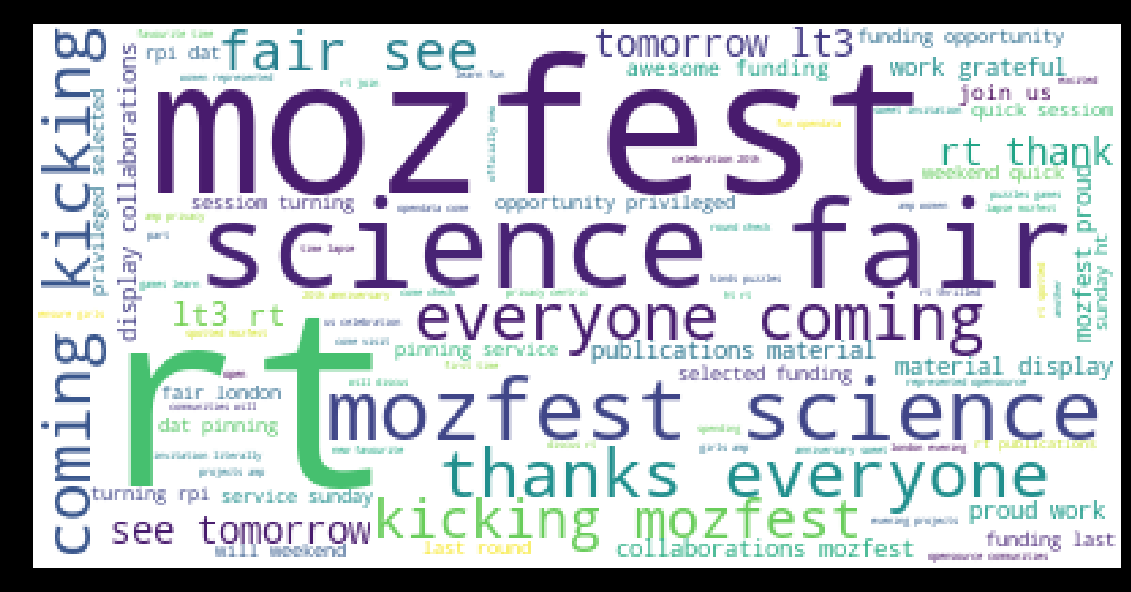

In [85]:
def wordcloud(tweets,col):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in tweets[col]]))
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Good Morning Datascience+")
wordcloud(tweets,'text')

In [86]:
tweets['location'] = tweets['location'].apply(lambda x: ' ' if x==None else str(x))

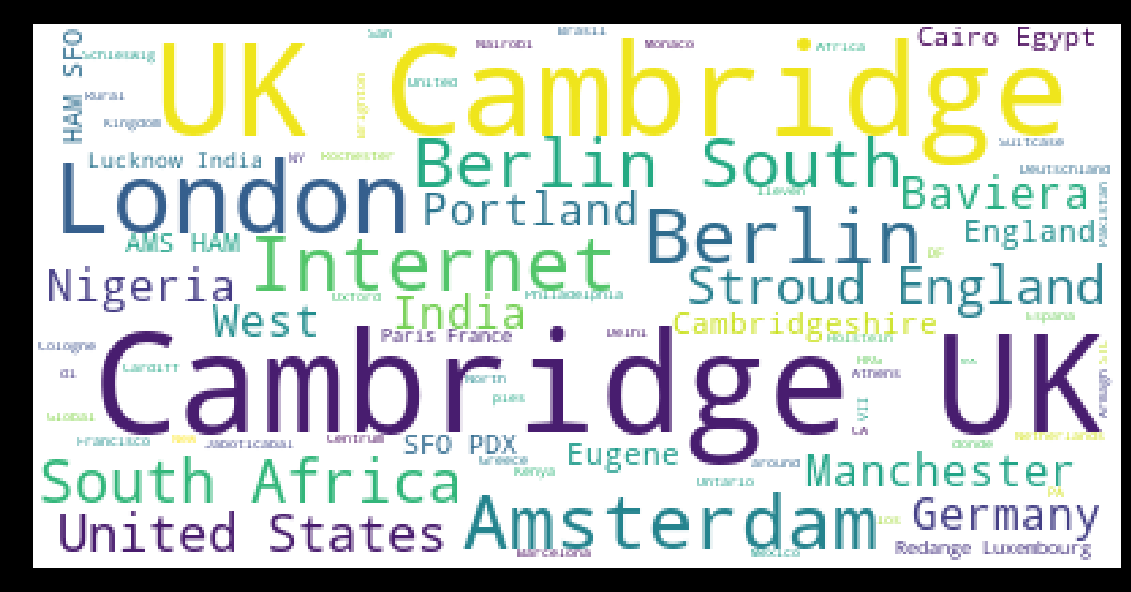

In [87]:
# tweets['location'] = tweets['location'].apply(lambda x: x.lower())
wordcloud(tweets, 'location')

In [88]:
tweets['source'][69]

'Twitter for iPhone'

In [89]:
tweets['source_new'] = ''

for i in range(len(tweets['source'])):
    m = re.search('(?i)<a([^>]+)>(.+?)</a>', tweets['source'][i])
    try:
        tweets['source_new'][i]=m.group(0)
    except AttributeError:
        tweets['source_new'][i]=tweets['source'][i]
        
tweets['source_new'] = tweets['source_new'].str.replace('', ' ', case=False)

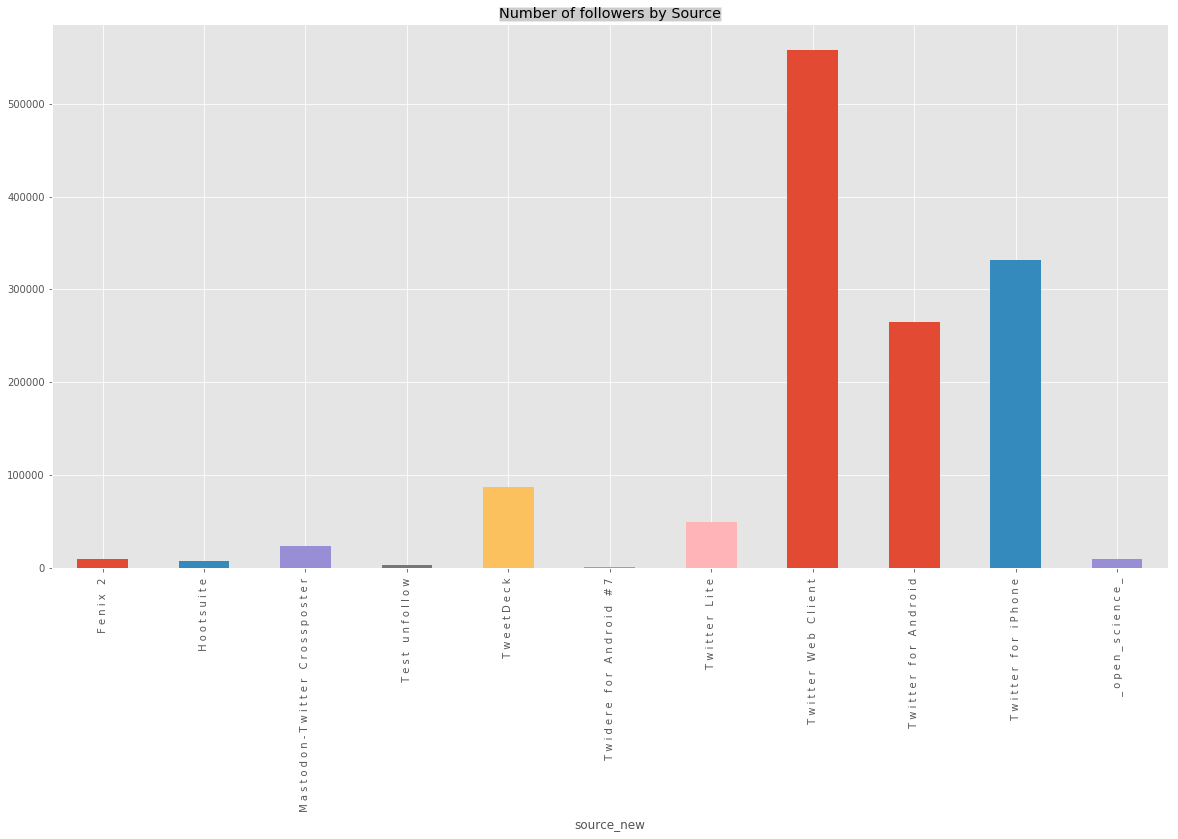

In [90]:
tweets_by_type = tweets.groupby(['source_new'])['followers_count'].sum()
plt.title('Number of followers by Source', bbox={'facecolor':'0.8', 'pad':0})
tweets_by_type.transpose().plot(kind='bar',figsize=(20, 10))

In [91]:
tweets['source_new2'] = ''

for i in range(len(tweets['source_new'])):
    if tweets['source_new'][i] not in ['Twitter for Android ','Instagram ','Twitter Web Client ','Twitter for iPhone ']:
        tweets['source_new2'][i] = 'Others'
    else:
        tweets['source_new2'][i] = tweets['source_new'][i] 

tweets_by_type2 = tweets.groupby(['source_new2'])['followers_count'].sum()
tweets_by_type2.rename("",inplace=True)
explode = (1,0,0,0,0)

In [92]:
tweets.groupby(['source_new2'])['followers_count'].count()

source_new2
Others    200
Name: followers_count, dtype: int64

In [93]:
tweets['text_lem'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in tweets['text']]       
vectorizer = TfidfVectorizer(max_df=0.5,max_features=10000,min_df=10,stop_words='english',use_idf=True)
X = vectorizer.fit_transform(tweets['text_lem'].str.upper())
sid = SentimentIntensityAnalyzer()
tweets['sentiment_compound_polarity']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['compound'])
tweets['sentiment_neutral']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['neu'])
tweets['sentiment_negative']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['neg'])
tweets['sentiment_pos']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['pos'])
tweets['sentiment_type']=''
tweets.loc[tweets.sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
tweets.loc[tweets.sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
tweets.loc[tweets.sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'

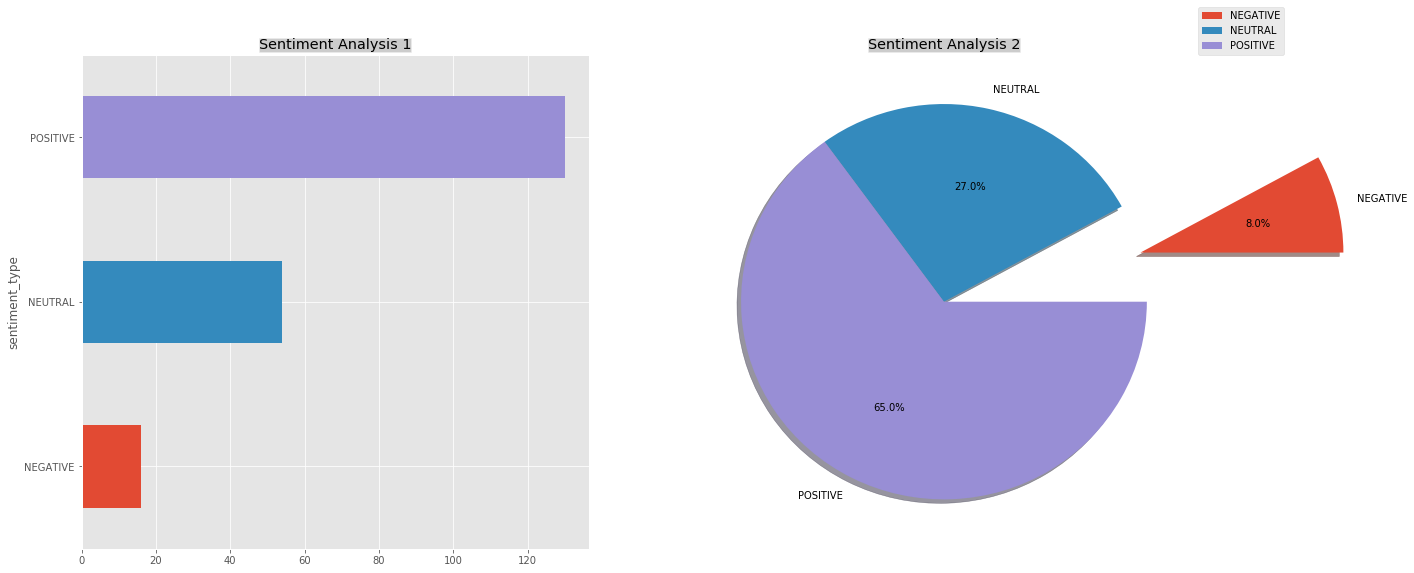

In [94]:
tweets_sentiment = tweets.groupby(['sentiment_type'])['sentiment_neutral'].count()
tweets_sentiment.rename("",inplace=True)
explode = (1, 0, 0)
plt.subplot(221)
tweets_sentiment.transpose().plot(kind='barh',figsize=(20, 20))
plt.title('Sentiment Analysis 1', bbox={'facecolor':'0.8', 'pad':0})
plt.subplot(222)
tweets_sentiment.plot(kind='pie',figsize=(20, 20),autopct='%1.1f%%',shadow=True,explode=explode)
plt.legend(bbox_to_anchor=(1, 1), loc=3, borderaxespad=0.)
plt.title('Sentiment Analysis 2', bbox={'facecolor':'0.8', 'pad':0})
plt.show()

In [95]:
tweets[tweets.sentiment_type == 'NEGATIVE'].text.reset_index(drop = True)[7]

'rt things to do this weekend ✅ learn to detect misinformation amp jam mobile trackers ✅ hear amp others…'

In [96]:
sid.polarity_scores("rt will you be at mozfest this weekend don’t miss our interactive conversation about youthsurveillance with")

{'neg': 0.096, 'neu': 0.904, 'pos': 0.0, 'compound': -0.1531}

In [ ]:
Warning: only 1-3% of Twitter data have geographical data

In [97]:
import pycountry
country = {}
for i in list(pycountry.countries):
    country[i.alpha_2] = i.name
    
loc = []
for i in tweets["location"]:
    j = i.split(",")
    if len(j)==1:
        if j[0].strip() in country.keys():
            loc.append(country[j[0].strip()])
        elif j[0].strip() in country.values():
            loc.append(j[0])
    else:
        if j[len(j)-1].strip() in country.keys():
            loc.append(country[j[len(j)-1].strip()])
        elif j[len(j)-1].strip() in country.values():
            loc.append(j[len(j)-1])
            
for i in range(len(loc)):
    loc[i] = loc[i].strip()
    
loc = list(loc)

In [98]:
country

{'AW': 'Aruba',
 'AF': 'Afghanistan',
 'AO': 'Angola',
 'AI': 'Anguilla',
 'AX': 'Åland Islands',
 'AL': 'Albania',
 'AD': 'Andorra',
 'AE': 'United Arab Emirates',
 'AR': 'Argentina',
 'AM': 'Armenia',
 'AS': 'American Samoa',
 'AQ': 'Antarctica',
 'TF': 'French Southern Territories',
 'AG': 'Antigua and Barbuda',
 'AU': 'Australia',
 'AT': 'Austria',
 'AZ': 'Azerbaijan',
 'BI': 'Burundi',
 'BE': 'Belgium',
 'BJ': 'Benin',
 'BQ': 'Bonaire, Sint Eustatius and Saba',
 'BF': 'Burkina Faso',
 'BD': 'Bangladesh',
 'BG': 'Bulgaria',
 'BH': 'Bahrain',
 'BS': 'Bahamas',
 'BA': 'Bosnia and Herzegovina',
 'BL': 'Saint Barthélemy',
 'BY': 'Belarus',
 'BZ': 'Belize',
 'BM': 'Bermuda',
 'BO': 'Bolivia, Plurinational State of',
 'BR': 'Brazil',
 'BB': 'Barbados',
 'BN': 'Brunei Darussalam',
 'BT': 'Bhutan',
 'BV': 'Bouvet Island',
 'BW': 'Botswana',
 'CF': 'Central African Republic',
 'CA': 'Canada',
 'CC': 'Cocos (Keeling) Islands',
 'CH': 'Switzerland',
 'CL': 'Chile',
 'CN': 'China',
 'CI': "Côt

In [99]:
unique_loc = list(set(loc))

c = []
for i in unique_loc:
    c.append(loc.count(i))
    
q = pd.DataFrame()

In [100]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
latitude = [] 
long = []
for i in unique_loc:
    if i != None:
        location = geolocator.geocode(i)
        if location!=None:
            latitude.append(location.latitude)#, location.longitude)
            long.append(location.longitude)
#         else: 
#             latitude.append("NA")
#             long.append("NA")
#     else:
#         latitude.append("NA")
#         long.append("NA")
# q["latitude"]  = tweets["location"].apply(lambda x :geolocator.geocode(x).latitude if (x !=None and geolocator.geocode(x)!=None) else None)

In [109]:
tweets['latitude'] = pd.Series(latitude)
tweets['longitude'] = pd.Series(long)
tweets.head()

,text,source,url,location,followers_count,tweetos,source_new,source_new2,text_lem,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type,latitude,longitude
0,this week in matrix 2018-10-26 is now availabl...,Twitter Web Client,http://twitter.com,,6529,other,T w i t t e r W e b C l i e n t,Others,this week in matrix is now availabl...,0.0000,1.000,0.000,0.000,NEUTRAL,39.783730,-100.445882
1,rt things to do this weekend ✅ learn to detect...,Twitter for iPhone,http://twitter.com/download/iphone,"Barcelona, España",1302,other,T w i t t e r f o r i P h o n e,Others,rt things to do this weekend learn to detect...,-0.3182,0.874,0.126,0.000,NEGATIVE,26.254049,29.267547
2,rt join us for the celebration of the 20th ann...,Twitter for Android,http://twitter.com/download/android,"Rochester, NY",46,other,T w i t t e r f o r A n d r o i d,Others,rt join us for the celebration of the th ann...,0.6369,0.714,0.000,0.286,POSITIVE,46.603354,1.888334
3,rt mozfest we are ready for you left to right ...,Twitter for Android,http://twitter.com/download/android,"Jaboticabal, Brasil",273,other,T w i t t e r f o r A n d r o i d,Others,rt mozfest we are ready for you left to right ...,0.5994,0.710,0.000,0.290,POSITIVE,51.083420,10.423447
4,rt this is an awesome funding opportunity i wa...,Twitter for iPhone,http://twitter.com/download/iphone,,13122,other,T w i t t e r f o r i P h o n e,Others,rt this is an awesome funding opportunity i wa...,0.8689,0.660,0.000,0.340,POSITIVE,8.309607,-81.306625


In [101]:
q = pd.DataFrame({"latitude":latitude,"longitude":long,"location":unique_loc,"count":c}) 

In [112]:
import folium
m = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)
 
# I can add marker one by one on the map

# london_location = [51.507351, -0.127758]


for i in range(0,len(q)):
    folium.Marker([q.iloc[i]['latitude'], q.iloc[i]['longitude']], popup=q.iloc[i]['location']).add_to(m) #+'('+str(q.iloc[i]['count'])+')'

m

In [113]:
tweets

,text,source,url,location,followers_count,tweetos,source_new,source_new2,text_lem,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type,latitude,longitude
0,this week in matrix 2018-10-26 is now availabl...,Twitter Web Client,http://twitter.com,,6529,other,T w i t t e r W e b C l i e n t,Others,this week in matrix is now availabl...,0.0000,1.000,0.000,0.000,NEUTRAL,39.783730,-100.445882
1,rt things to do this weekend ✅ learn to detect...,Twitter for iPhone,http://twitter.com/download/iphone,"Barcelona, España",1302,other,T w i t t e r f o r i P h o n e,Others,rt things to do this weekend learn to detect...,-0.3182,0.874,0.126,0.000,NEGATIVE,26.254049,29.267547
2,rt join us for the celebration of the 20th ann...,Twitter for Android,http://twitter.com/download/android,"Rochester, NY",46,other,T w i t t e r f o r A n d r o i d,Others,rt join us for the celebration of the th ann...,0.6369,0.714,0.000,0.286,POSITIVE,46.603354,1.888334
3,rt mozfest we are ready for you left to right ...,Twitter for Android,http://twitter.com/download/android,"Jaboticabal, Brasil",273,other,T w i t t e r f o r A n d r o i d,Others,rt mozfest we are ready for you left to right ...,0.5994,0.710,0.000,0.290,POSITIVE,51.083420,10.423447
4,rt this is an awesome funding opportunity i wa...,Twitter for iPhone,http://twitter.com/download/iphone,,13122,other,T w i t t e r f o r i P h o n e,Others,rt this is an awesome funding opportunity i wa...,0.8689,0.660,0.000,0.340,POSITIVE,8.309607,-81.306625
5,rt we will be this weekend doing a quick sessi...,Twitter for iPhone,http://twitter.com/download/iphone,,6253,other,T w i t t e r f o r i P h o n e,Others,rt we will be this weekend doing a quick sessi...,0.0000,1.000,0.000,0.000,NEUTRAL,9.600036,7.999972
6,rt spending the weekend connecting with the di...,Twitter for iPhone,http://twitter.com/download/iphone,"Cairo, Egypt",273,other,T w i t t e r f o r i P h o n e,Others,rt spending the weekend connecting with the di...,0.0000,1.000,0.000,0.000,NEUTRAL,22.351115,78.667743
7,rt thanks everyone for coming out and kicking ...,Twitter for iPhone,http://twitter.com/download/iphone,"Cairo, Egypt",273,other,T w i t t e r f o r i P h o n e,Others,rt thanks everyone for coming out and kicking ...,0.6369,0.766,0.000,0.234,POSITIVE,49.815868,6.129675
8,rt how do we ensure that girls amp women are r...,Twidere for Android #7,https://github.com/mariotaku/twidere/,,286,other,T w i d e r e f o r A n d r o i d # 7,Others,rt how do we ensure that girls amp women are r...,0.3818,0.860,0.000,0.140,POSITIVE,61.066692,-107.991707
9,rt how do we ensure that girls amp women are r...,Twitter for iPhone,http://twitter.com/download/iphone,AMS - HAM - SFO - PDX,6376,other,T w i t t e r f o r i P h o n e,Others,rt how do we ensure that girls amp women are r...,0.3818,0.860,0.000,0.140,POSITIVE,1.441968,38.431398
